In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import cv2

import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# nn
from keras.layers import Dense, Activation,Conv2D, MaxPool2D, AveragePooling2D, ZeroPadding2D,BatchNormalization
from keras.layers import GlobalAveragePooling2D, Input, Concatenate, Dropout,Flatten,Dropout
from keras.models import Model,Sequential,load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, Callback


import warnings
warnings.filterwarnings('ignore')

In [ ]:

directory = "/content/drive/MyDrive/covid_xray/"
train_dir1 = os.path.join(directory, "train/")
test_dir1 = os.path.join(directory, "test/")
val_dir1 = os.path.join(directory, "val/")

In [ ]:
print("Number of images in Train is {}".format(len(glob(train_dir1 + "*/*"))))
print("Number of images in Test is {}".format(len(glob(test_dir1 + "*/*"))))
print("Number of images in Validation is {}".format(len(glob(val_dir1 + "*/*"))))


Number of images in Train is 5216
Number of images in Test is 624
Number of images in Validation is 16


In [ ]:
train_classes=os.listdir(train_dir1)


In [ ]:
xr=[]
yr=[]
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
for folder in os.listdir(train_dir1):
    image_list=os.listdir(train_dir1+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_dir1+"/"+folder+"/"+img_name,target_size=(150,150))
        
        # Converting to arrary
        img=image.img_to_array(img)
        
        # Transfer Learning: this is to apply preprocess of VGG16 model to our images before passing it to VGG16
        img=preprocess_input(img) #  Optional step
        
        # Appending the arrarys
        xr.append(img) # appending image array
        yr.append(train_classes.index(folder)) # appending class index to the array
        
print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [ ]:
os.listdir(train_dir1)

#so 0 means normal and 1 means pneumonia

['NORMAL', 'PNEUMONIA']

In [ ]:
from keras.utils import to_categorical

xr=np.array(xr)
yr=to_categorical(yr) # onehot encoding of the labels
yr.shape

(5216, 2)

# **ResNet**

In [ ]:
from keras.applications.resnet50 import ResNet50


In [ ]:

resnet50 = ResNet50(weights= 'imagenet', include_top=False, input_shape= (150,150,3))

#freazing the trained layers
for layers in resnet50.layers:
    layers.trainable = False
#pretrained_model3.summary()

In [ ]:
from keras.optimizers import RMSprop

last_layer=resnet50.get_layer('conv5_block3_1_relu')
last_output = last_layer.output

x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(2,activation='softmax')(x)

resmodel50=Model(resnet50.input,x)

resmodel50.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','AUC'])


In [ ]:
resmodel50.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# **Train test split**

In [ ]:
from sklearn.model_selection import train_test_split
xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(xr,yr,test_size=0.2,random_state=5)


In [ ]:

learning_rate_reduction1 = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history2=resmodel50.fit(xtrain_r,ytrain_r,epochs=12,verbose=True,
          validation_data=(xtest_r,ytest_r),callbacks=[learning_rate_reduction1])


Epoch 1/12
131/131 [==============================] - 403s 3s/step - loss: 0.4925 - accuracy: 0.8677 - auc: 0.9229 - val_loss: 0.0921 - val_accuracy: 0.9703 - val_auc: 0.9856
Epoch 2/12
131/131 [==============================] - 397s 3s/step - loss: 0.0714 - accuracy: 0.9788 - auc: 0.9897 - val_loss: 0.0738 - val_accuracy: 0.9799 - val_auc: 0.9923
Epoch 3/12
131/131 [==============================] - 395s 3s/step - loss: 0.0406 - accuracy: 0.9882 - auc: 0.9959 - val_loss: 0.0623 - val_accuracy: 0.9837 - val_auc: 0.9910
Epoch 4/12
131/131 [==============================] - 400s 3s/step - loss: 0.0231 - accuracy: 0.9932 - auc: 0.9975 - val_loss: 0.0742 - val_accuracy: 0.9856 - val_auc: 0.9911
Epoch 5/12
131/131 [==============================] - 395s 3s/step - loss: 0.0098 - accuracy: 0.9976 - auc: 0.9992 - val_loss: 0.1279 - val_accuracy: 0.9866 - val_auc: 0.9903
Epoch 6/12
131/131 [==============================] - 395s 3s/step - loss: 0.0111 - accuracy: 0.9964 - auc: 0.9990 - val_loss

# **Evaluation**

In [ ]:
print("Loss of the model is - " , resmodel50.evaluate(xtest_r,ytest_r)[0])
print("Accuracy of the model is - " , resmodel50.evaluate(xtest_r,ytest_r)[1]*100 , "%")


33/33 [==============================] - 66s 2s/step - loss: 0.1626 - accuracy: 0.9847
Loss of the model is -  0.16263309121131897
33/33 [==============================] - 66s 2s/step - loss: 0.1626 - accuracy: 0.9847
Accuracy of the model is -  98.4674334526062 %


# **AUC**

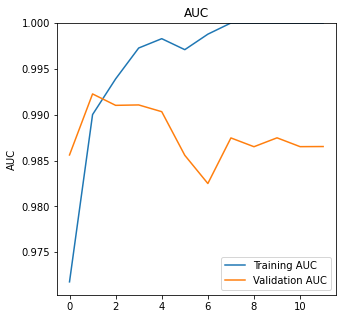

In [ ]:

aucr = history2.history['auc']
val_aucr = history2.history['val_auc']

plt.figure(figsize=(5, 5))
plt.plot(aucr, label='Training AUC')
plt.plot(val_aucr, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('AUC')

plt.show();

In [ ]:
predictionsr = resmodel50.predict(xtest_r)
predictionsr[:15]


array([[1.0000000e+00, 4.9093080e-23],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [4.3439161e-16, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 6.5005390e-27],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [3.4801053e-23, 1.0000000e+00],
       [1.0000000e+00, 4.2831947e-33],
       [2.5491576e-33, 1.0000000e+00]], dtype=float32)

In [ ]:
int(predictionsr[0][1])

0

In [ ]:
rpredy=[]
for i in range(0,len(predictionsr)):
    rpredy.append(int(predictionsr[i][1]))


In [ ]:
rtruey=[]
for i in range(0,len(predictionsr)):
    rtruey.append(int(ytest_r[i][1]))


In [ ]:
rpredy[:15]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [ ]:
rtruey[:15]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]

# **Predictions**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

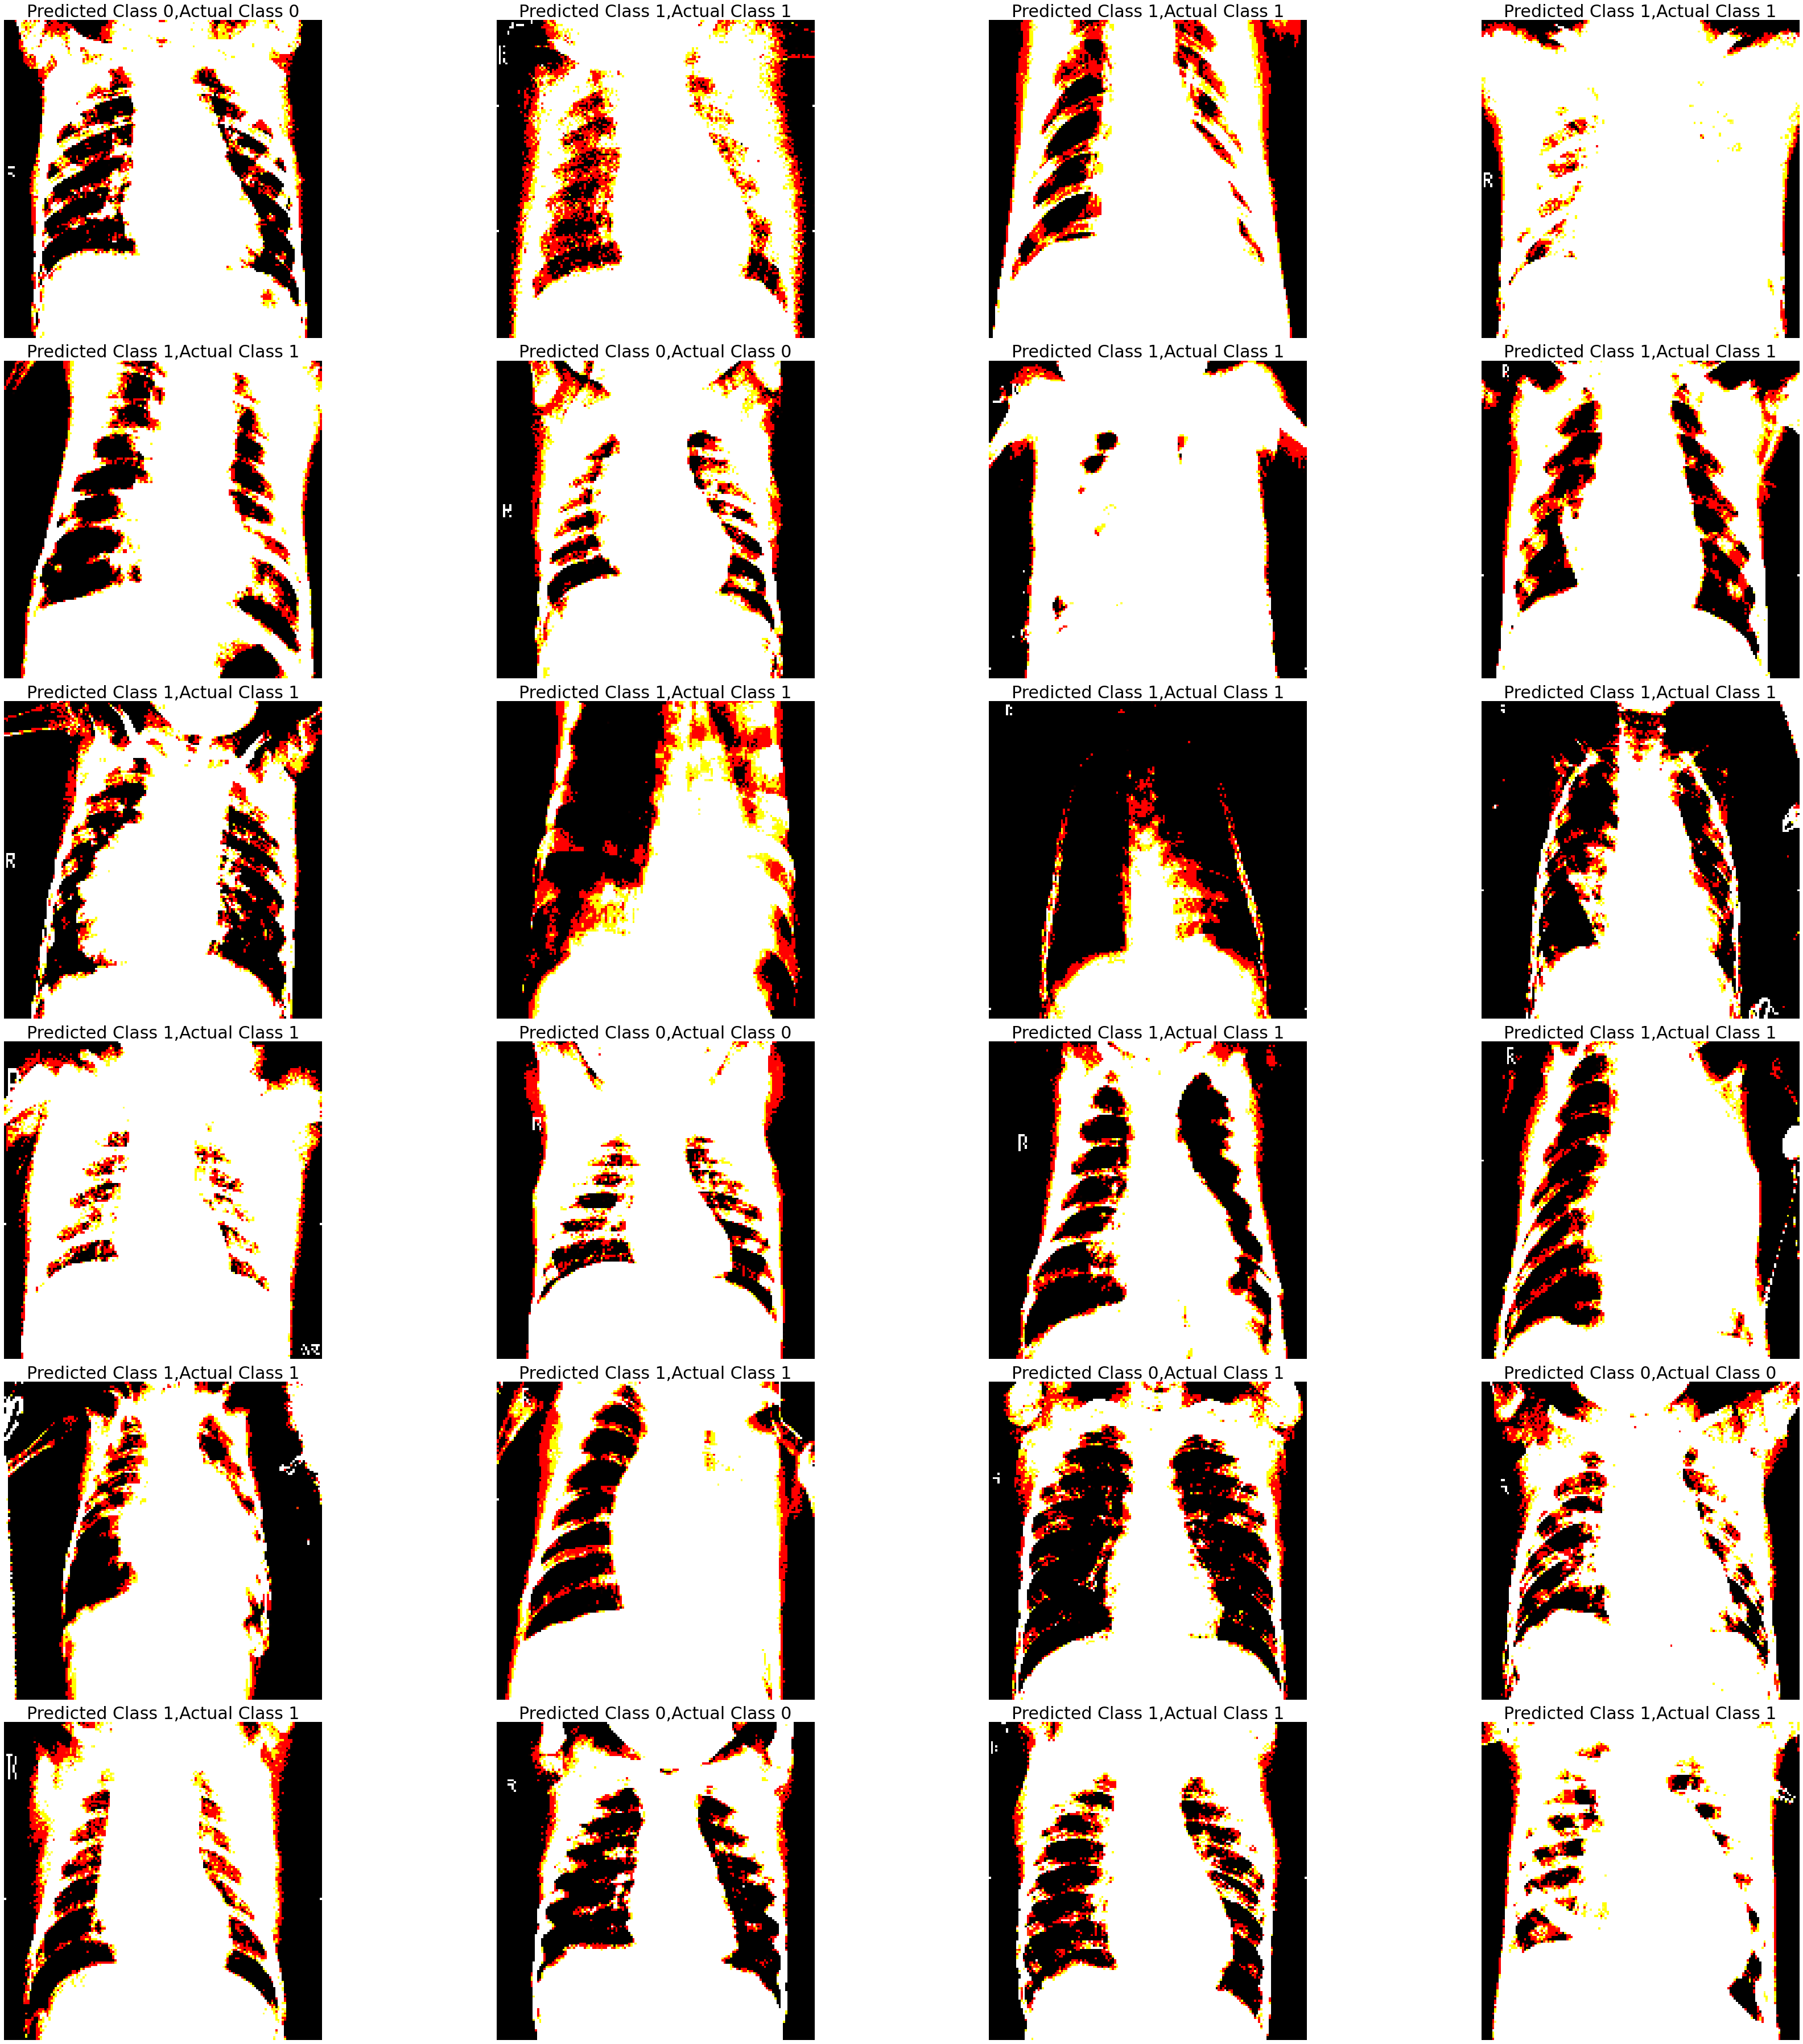

In [ ]:
i = 0
plt.figure(figsize=(50,50))

for x in range(0,24):
    plt.subplot(6,4,i+1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(xtest_r[x],  interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(rpredy[x], rtruey[x]),fontdict = {'fontsize' : 30})
    i += 1

    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

# **Classifiation report**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(rtruey, rpredy, target_names = ['Normal(Class 0)','Pneumonia (Class 1)']))


                     precision    recall  f1-score   support

    Normal(Class 0)       0.94      0.99      0.97       262
Pneumonia (Class 1)       1.00      0.98      0.99       782

           accuracy                           0.98      1044
          macro avg       0.97      0.99      0.98      1044
       weighted avg       0.98      0.98      0.98      1044



# **Confusion Matrix**

In [ ]:
cmr = confusion_matrix(rtruey,rpredy)
cmr

array([[260,   2],
       [ 16, 766]])

# **Sensitivity and Specificity**

In [ ]:
sensitivityr=cmr[0][0]/(cmr[0][0]+cmr[1][0])
print(sensitivityr)
print(sensitivityr*100)

0.9420289855072463
94.20289855072464


In [ ]:
specificityr=cmr[1][1]/(cmr[1][1]+cmr[0][1])
print(specificityr)
print(specificityr*100)

0.9973958333333334
99.73958333333334


# **InceptionV3**

In [ ]:
from keras.applications import InceptionV3
from keras.optimizers import  SGD
incmodel= InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(150, 150,3))
incmodel.trainable = False

inception = Sequential()
inception.add(incmodel)
inception.add(GlobalAveragePooling2D())
inception.add(BatchNormalization())
inception.add(Dropout(0.5))
inception.add(Dense(1024,activation='relu'))
inception.add(Dense(128,activation='relu'))
inception.add(BatchNormalization())
inception.add(Dropout(0.5))
inception.add(Dense(2,activation='sigmoid'))

inmodel = inception
inmodel.compile(loss='binary_crossentropy', 
              optimizer=SGD(lr=1e-4),
              metrics=['accuracy','AUC'])
inmodel.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_292 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               131200    
_________________________________________________________________
batch_normalization_293 (Bat (None, 128)              

In [ ]:
xv=[]
yv=[]
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
for folder in os.listdir(train_dir1):
    image_list=os.listdir(train_dir1+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_dir1+"/"+folder+"/"+img_name,target_size=(150,150))
        
        # Converting to arrary
        img=image.img_to_array(img)
        
        # Transfer Learning: this is to apply preprocess of VGG16 model to our images before passing it to VGG16
        img=preprocess_input(img) #  Optional step
        
        # Appending the arrarys
        xv.append(img) # appending image array
        yv.append(train_classes.index(folder)) # appending class index to the array
        
print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [ ]:
os.listdir(train_dir1)

['NORMAL', 'PNEUMONIA']

In [ ]:
from keras.utils import to_categorical

xv=np.array(xv)
yv=to_categorical(yv) # onehot encoding of the labels
yv.shape

(5216, 2)

# **Train test split**

In [ ]:
from sklearn.model_selection import train_test_split
xtrain_i, xtest_i, ytrain_i, ytest_i = train_test_split(xv,yv,test_size=0.2,random_state=5)


In [ ]:


historyv=inmodel.fit(xtrain_i,ytrain_i,epochs=12,verbose=True,
          validation_data=(xtest_i,ytest_i),callbacks=[learning_rate_reduction1])


Epoch 1/12
131/131 [==============================] - 215s 2s/step - loss: 1.0691 - accuracy: 0.5106 - auc: 0.5205 - val_loss: 0.8615 - val_accuracy: 0.4406 - val_auc: 0.4330
Epoch 2/12
131/131 [==============================] - 211s 2s/step - loss: 1.0016 - accuracy: 0.5482 - auc: 0.5464 - val_loss: 0.8021 - val_accuracy: 0.5029 - val_auc: 0.5248
Epoch 3/12
131/131 [==============================] - 207s 2s/step - loss: 0.9402 - accuracy: 0.5837 - auc: 0.5797 - val_loss: 0.7495 - val_accuracy: 0.5661 - val_auc: 0.5965
Epoch 4/12
131/131 [==============================] - 206s 2s/step - loss: 0.9066 - accuracy: 0.5946 - auc: 0.6028 - val_loss: 0.7064 - val_accuracy: 0.6207 - val_auc: 0.6466
Epoch 5/12
131/131 [==============================] - 209s 2s/step - loss: 0.8630 - accuracy: 0.6184 - auc: 0.6324 - val_loss: 0.6705 - val_accuracy: 0.6418 - val_auc: 0.6855
Epoch 6/12
131/131 [==============================] - 208s 2s/step - loss: 0.8573 - accuracy: 0.6338 - auc: 0.6394 - val_loss

# **Evaluation**

In [ ]:
print("Loss of the model is - " , inmodel.evaluate(xtest_i,ytest_i)[0])
print("Accuracy of the model is - " , inmodel.evaluate(xtest_i,ytest_i)[1]*100 , "%")


33/33 [==============================] - 43s 1s/step - loss: 0.5434 - accuracy: 0.7481 - auc: 0.8086
Loss of the model is -  0.5433607697486877
33/33 [==============================] - 41s 1s/step - loss: 0.5434 - accuracy: 0.7481 - auc: 0.8086
Accuracy of the model is -  74.8084306716919 %


In [ ]:
predictionsi = inmodel.predict_classes(xtest_i)
predictionsi[:15]


array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
itruey=[]
for i in range(0,len(predictionsi)):
    itruey.append(int(ytest_i[i][1]))


In [ ]:
icorr=[]
iincorr=[]
for i in range(0,len(predictionsi)):
  if(predictionsi[i]==itruey[i]):
    icorr.append(i)
  else:
    iincorr.append(i)

In [ ]:
len(icorr)

781

In [ ]:
len(iincorr)

263

In [ ]:
#index where prediction was wrong
print(iincorr)

[3, 6, 8, 11, 12, 14, 16, 18, 20, 22, 23, 28, 35, 37, 41, 43, 55, 59, 61, 62, 64, 67, 69, 77, 82, 83, 86, 88, 97, 100, 102, 104, 105, 114, 119, 123, 130, 136, 138, 143, 148, 149, 152, 154, 157, 164, 169, 173, 174, 175, 180, 182, 183, 185, 186, 188, 189, 190, 192, 193, 194, 210, 215, 216, 217, 223, 225, 226, 231, 232, 236, 240, 243, 246, 248, 264, 273, 277, 286, 289, 295, 303, 308, 309, 312, 313, 316, 318, 319, 323, 327, 336, 338, 339, 342, 344, 349, 350, 351, 352, 353, 354, 356, 364, 370, 373, 380, 386, 387, 388, 390, 400, 406, 407, 408, 411, 413, 416, 420, 421, 432, 433, 439, 441, 442, 448, 456, 469, 470, 471, 472, 473, 476, 481, 482, 496, 499, 500, 514, 519, 520, 544, 549, 555, 562, 564, 565, 571, 575, 576, 581, 593, 595, 598, 599, 606, 613, 624, 625, 634, 638, 645, 659, 670, 676, 677, 678, 679, 680, 683, 685, 687, 688, 689, 692, 698, 699, 703, 707, 712, 716, 718, 719, 722, 728, 729, 730, 738, 741, 749, 761, 763, 766, 772, 783, 789, 802, 803, 806, 807, 810, 818, 823, 824, 828, 830, 8

# **Predictions**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

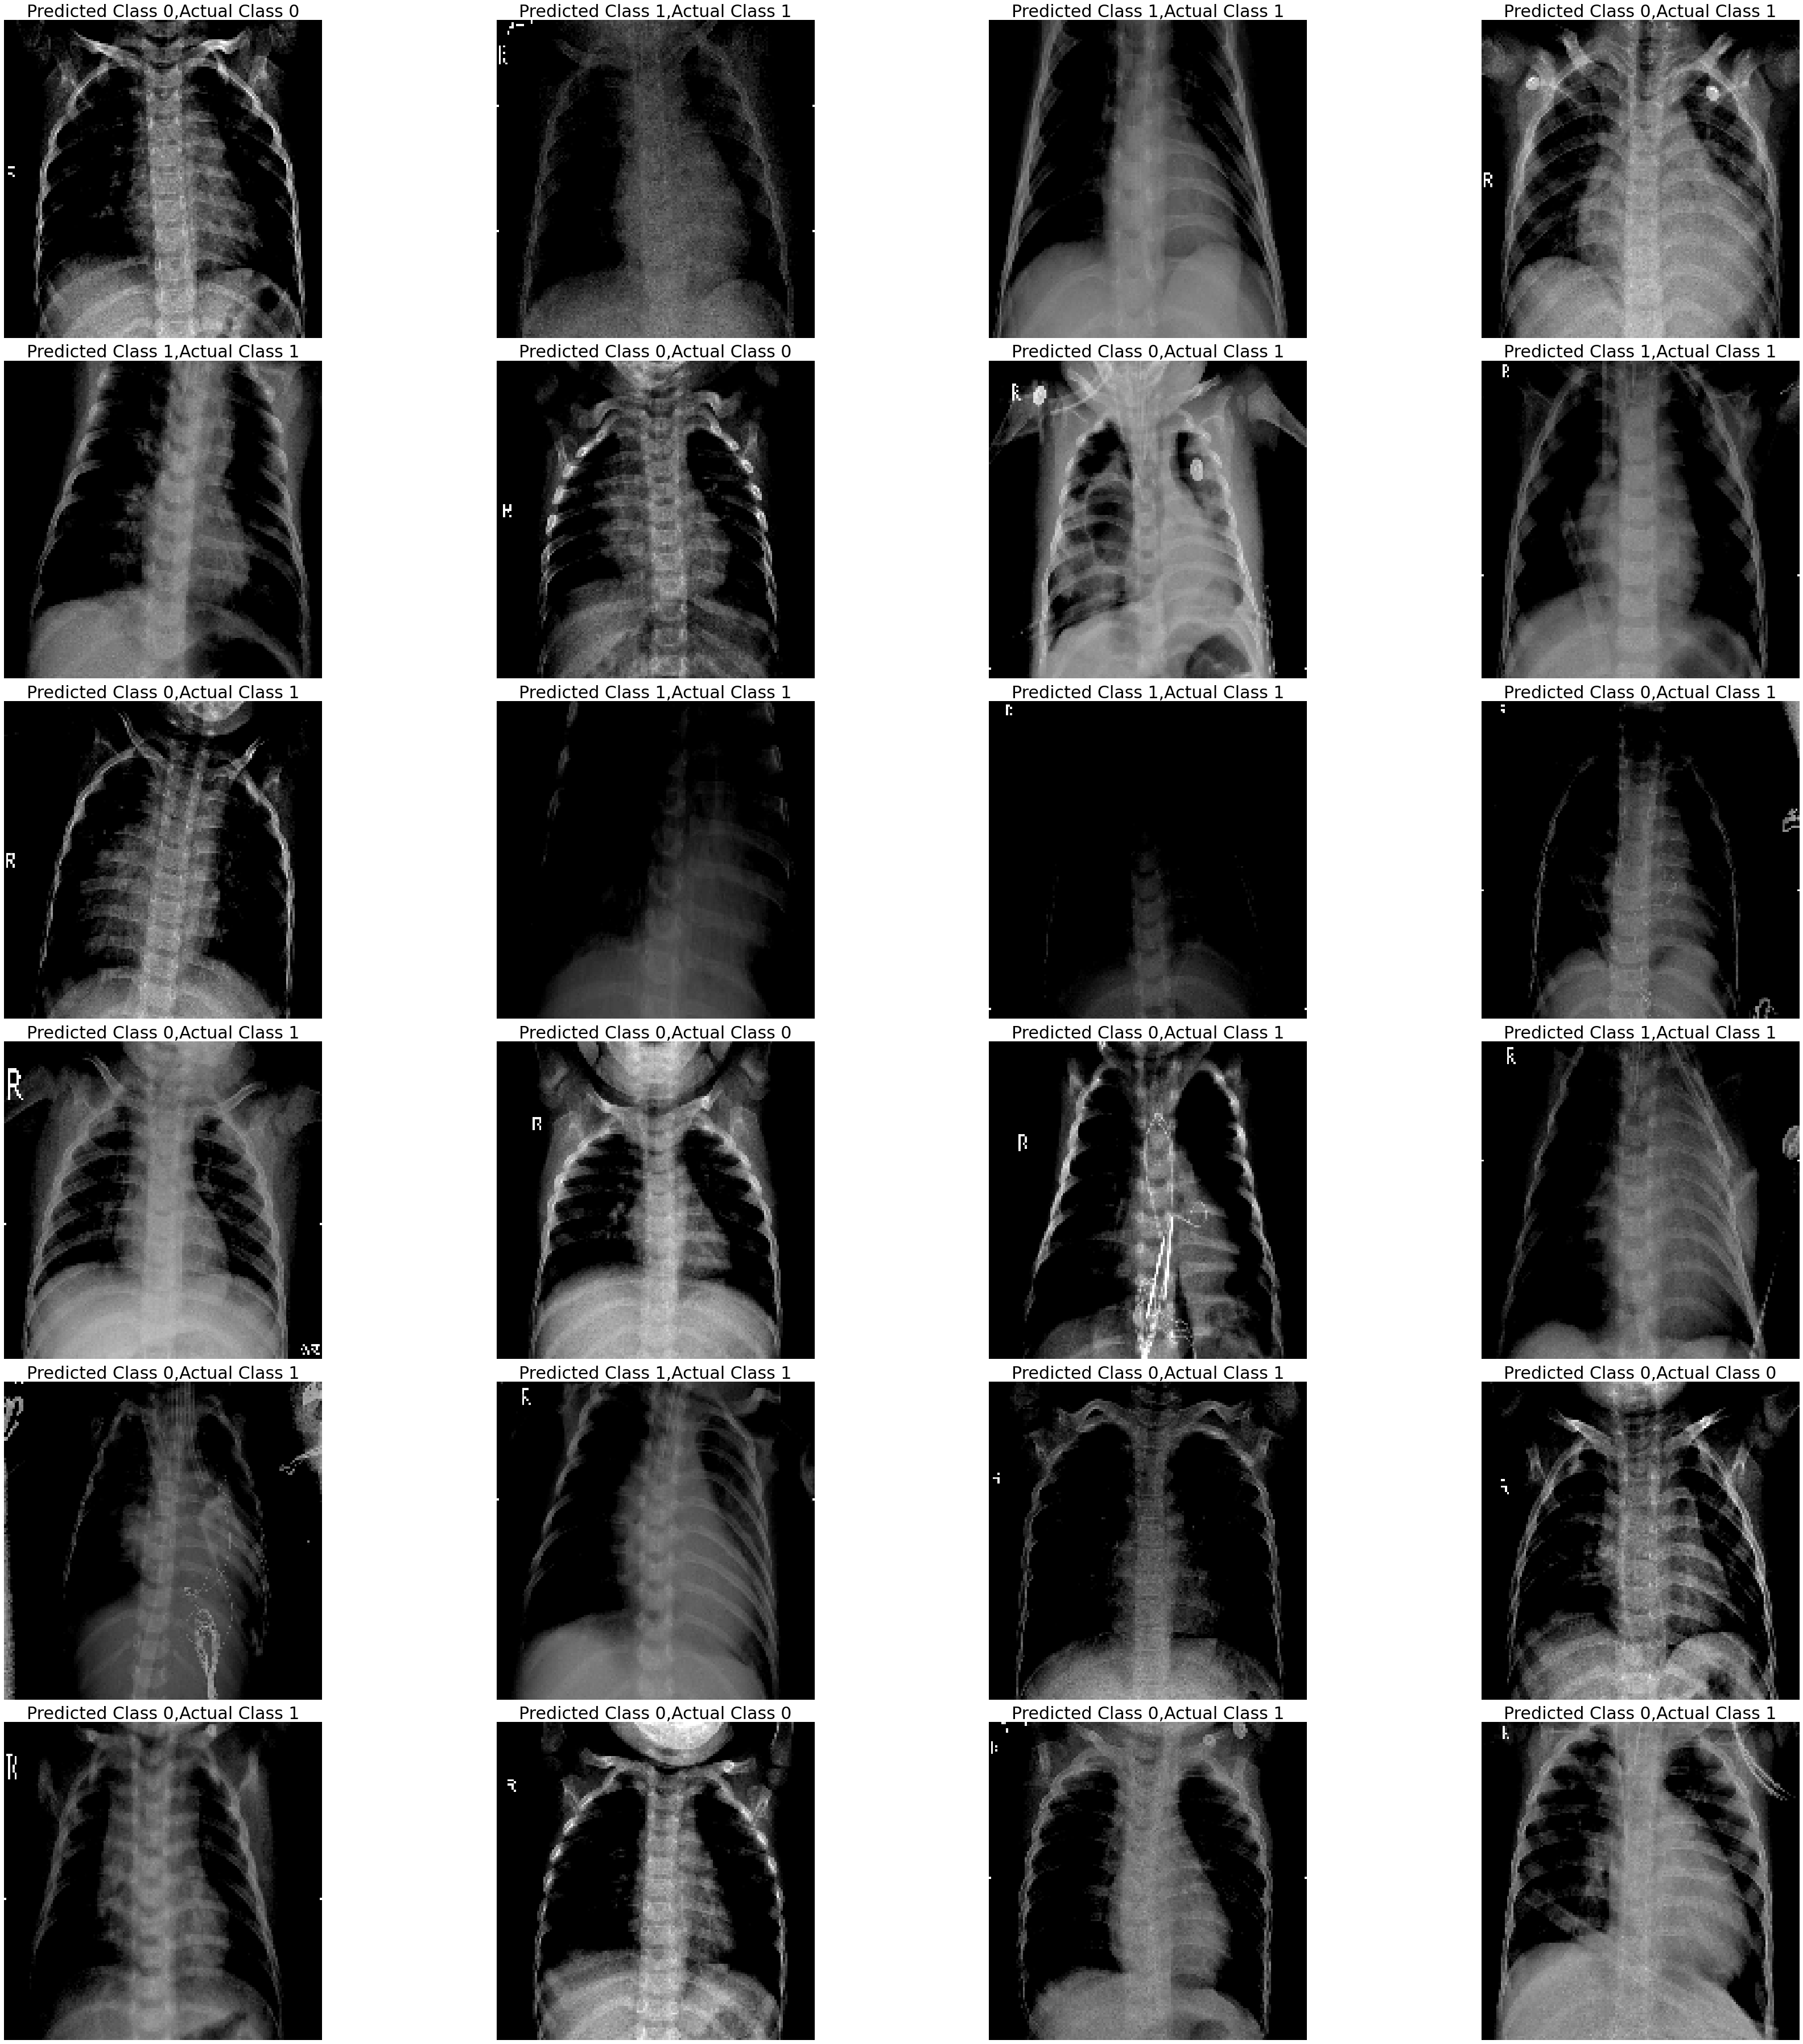

In [ ]:
i = 0
plt.figure(figsize=(50,50))

for x in range(0,24):
    plt.subplot(6,4,i+1)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(xtest_i[x],  interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictionsi[x], itruey[x]),fontdict = {'fontsize' : 30})
    i += 1

    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

# **Classification report**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(itruey, predictionsi, target_names = ['Normal(Class 0)','Pneumonia (Class 1)']))


                     precision    recall  f1-score   support

    Normal(Class 0)       0.50      0.95      0.66       262
Pneumonia (Class 1)       0.98      0.68      0.80       782

           accuracy                           0.75      1044
          macro avg       0.74      0.82      0.73      1044
       weighted avg       0.86      0.75      0.76      1044



# **Confusion Matrix**

In [ ]:
cmi = confusion_matrix(itruey,predictionsi)
cmi

array([[250,  12],
       [251, 531]])

# **Sensitivity and Specificity**

In [ ]:
sensitivityi=cmi[0][0]/(cmi[0][0]+cmi[1][0])
print(sensitivityi)
print(sensitivityi*100)

0.499001996007984
49.9001996007984


In [ ]:
specificityi=cmi[1][1]/(cmi[1][1]+cmi[0][1])
print(specificityi)
print(specificityi*100)

0.9779005524861878
97.79005524861878


# **AUC**

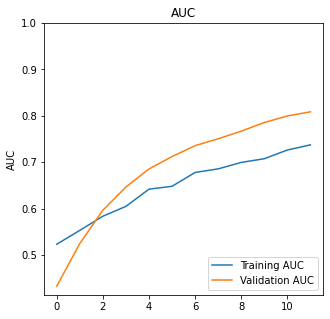

In [ ]:

auci = historyv.history['auc']
val_auci = historyv.history['val_auc']

plt.figure(figsize=(5, 5))
plt.plot(auci, label='Training AUC')
plt.plot(val_auci, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('AUC')

plt.show();